In [1]:
# %matplotlib inline
import numpy as np
import scipy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt

from utils import *

mpl.rcParams.update(rcParams)

In [2]:
%%bash
cd .. && make clean && make

In file included from src/Exercice5_students.cpp:7:
src/ConfigFile.tpp:67:8: warning: variable 'out' is used uninitialized whenever 'if' condition is false [-Wsometimes-uninitialized]
  if ( val != configMap.end() ) {
       ^~~~~~~~~~~~~~~~~~~~~~
src/Exercice5_students.cpp:164:33: note: in instantiation of function template specialization 'ConfigFile::get<double>' requested here
        const double tfin = configFile.get<double>("tfin");
                                       ^
src/ConfigFile.tpp:74:10: note: uninitialized use occurs here
  return out;
         ^~~
src/ConfigFile.tpp:67:3: note: remove the 'if' if its condition is always true
  if ( val != configMap.end() ) {
  ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
src/ConfigFile.tpp:66:8: note: initialize the variable 'out' to silence this warning
  T out;
       ^
        = 0.0
src/ConfigFile.tpp:67:8: warning: variable 'out' is used uninitialized whenever 'if' condition is false [-Wsometimes-uninitialized]
  if ( val != configMap.end() ) 

In [3]:
config_name = 'bassindefault'
conf = load_conf(config_name)

g = 9.81

In [4]:
tfin = (conf['xR']-conf['xL']) * 4 / np.sqrt(conf['h00']*g)

# params, data_x, data_v, data_f
dataset = run_with_params(
    config_name,
    gen_variations({
        'initial_state': ['left', 'right', 'static'],
        'tfin': [tfin],
        'impose_nsteps': ['true'],
        'nsteps': [4*conf['nx'] + 1]
    })
)

Running simulations... Done 3/3


[ConfigFile] Ligne sans '=' : "# Physique :"
[ConfigFile] Ligne sans '=' : "# Physique :"
[ConfigFile] Ligne sans '=' : "# Physique :"


# plots AND ANIMATIONS!

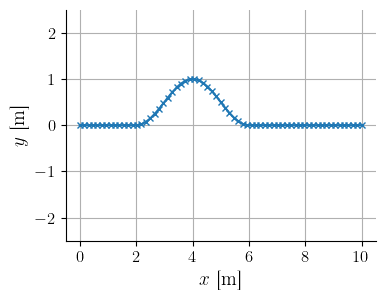

In [5]:
%matplotlib inline

params, x, v, f, _ = dataset[0]

plt.plot(x, f[0,1:], 'x-', markersize=5)
plt.xlabel(r'$x$ [m]')
plt.ylabel(r'$y$ [m]')
plt.ylim(-2.5, 2.5)
plt.grid()
plt.savefig(export_path + 'bassin_default_start.pdf')

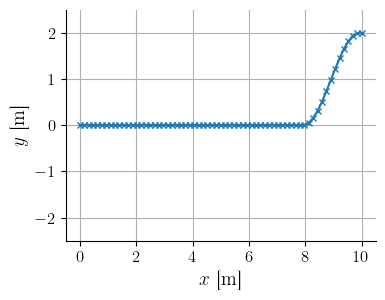

In [6]:
%matplotlib inline

index_max = np.argmax(np.max(f[:,1:], axis=1))
plt.plot(x, f[index_max,1:], 'x-', markersize=5)
plt.xlabel(r'$x$ [m]')
plt.ylabel(r'$y$ [m]')
plt.ylim(-2.5, 2.5)
plt.grid()
plt.savefig(export_path + 'bassin_default_reflection_max.pdf')

In [7]:
import matplotlib.animation as mpla

%matplotlib qt

# 0 for left, 1 for right, 2 for static
selected = 2

params, x, v, f, _ = dataset[selected]

plt.figure(figsize=(8, 8))

line, = plt.plot(x, f[0,1:], 'x-', markersize=5)
size = f.shape[0]

def animate(i) -> Any:
    idx = i % size
    line.set_data(x, f[idx,1:])

anim = mpla.FuncAnimation(plt.gcf(), animate, interval=20, cache_frame_data=True, frames=size)

plt.xlabel(r'$x$ [m]')
plt.ylabel(r'$y$ [m]')
plt.ylim(-2, 2)
plt.grid()

# Plots color!

In [8]:
def plot_color(datass, name):
    params, x, v, f, h0 = datass
    t = f[:,0]
    h = f[:,1:]
    X, Y = np.meshgrid(x, t)
    plt.contourf(X, Y, h, levels=20, cmap=plt.get_cmap('viridis'))
    plt.colorbar().set_label(r'$f(x,t)$ [m]')
    plt.xlabel(r'$x$ [m]')
    plt.ylabel(r'$t$ [s]')
    
    plt.savefig(export_path + 'bassin_default_'+name+'.png')

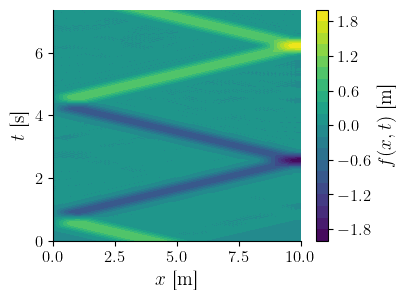

In [9]:
%matplotlib inline

plot_color(datass=dataset[0], name='left')

# params, x, v, f, h0 = dataset[0]
# t = f[:,0]
# h = f[:,1:]
# X, Y = np.meshgrid(x, t)
# plt.contourf(X, Y, h, levels=20, cmap=plt.get_cmap('viridis'))
# plt.colorbar()
# plt.xlabel(r'$x$ [m]')
# plt.ylabel(r'$t$ [s]')

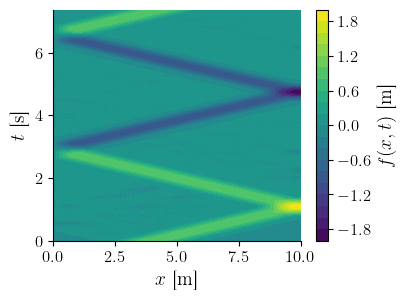

In [10]:
plot_color(datass=dataset[1], name='right')

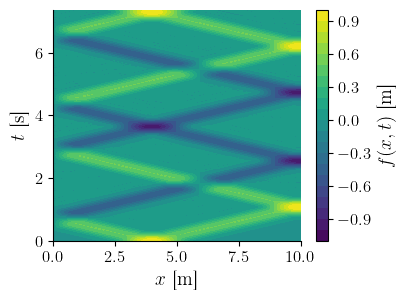

In [11]:
plot_color(datass=dataset[2], name='static')